In [ ]:
#default_exp interpretation

# Interpretation

`ClassificationInterpretation` style class for regression tasks.

In [ ]:
# export
from fastai.vision.data import get_grid
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
from fastai.tabular.all import *
from fastai.interpret import *
from fastai.metrics import *
from enveco.metrics import *
from fastai.test_utils import synth_learner
import torch

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
#export

class RegressionInterpretation(Interpretation):
    "Interpretation for regression models"
    
    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        super().__init__(dl, inputs, preds, targs, decoded, losses)
        
    def plot_results(self, title='Regression results', log_y:bool=False, **kwargs) -> plt.Axes:
        "Plot result image for regression tasks, code still need prettifying"
        if not hasattr(self.dl, 'c'): self.dl.c = 1
        axs = get_grid(self.dl.c, figsize=((6+1)*self.dl.c, (6)*self.dl.c)) # if we have multitarget
        if log_y: 
            self.targs = torch.expm1(self.targs)
            self.preds = torch.expm1(self.preds)
        if len(self.targs.shape) == 1: self.targs = self.targs[:,None]
        for i, a in enumerate(axs):
            im = a.scatter(self.targs[:,i], self.preds[:,i], c=torch.abs(self.targs[:,i]-self.preds[:,i]))
            a.set_xlabel('Real value')
            a.set_ylabel('Predicted value')
            if hasattr(self.dl, 'y_names'):
                a.set_title(self.dl.y_names[i])
            else:
                a.set_title('Results')
            a.grid()
            x = np.linspace(0, max(self.preds[:,i].max(),self.targs[:,i].max()))
            a.plot(x, x, color='orange')
            m, b = np.polyfit(self.targs[:,i], self.preds[:,i], 1)
            a.plot(x, m*x+b, color='blue')
            cbar = plt.colorbar(im, ax=a)
            cbar.ax.set_ylabel('Deviations', rotation=90)
            
            labels = []
            res_mse = mse(self.targs[:,i], self.preds[:,i])
            labels.append(f'MSE: {res_mse:.2f}')

            res_rmse = rmse(self.targs[:,i], self.preds[:,i]) 
            labels.append(f'RMSE: {res_rmse:.2f}'
                         )
            res_rrmse = res_rmse / self.targs[:,i].mean() * 100
            labels.append(f'RRMSE: {res_rrmse:.2f}%')
        
            res_mae = mae(self.targs[:,i], self.preds[:,i])
            labels.append(f'MAE: {res_mae:.2f}')

            r2 = R2Score()(self.preds[:,i], self.targs[:,i])
            labels.append(f'R2: {r2:.2f}')
            if isinstance(self.dl, TabDataLoader):
                adjusted_r2 = adjusted_R2Score(r2, self.inputs[1].shape[0], self.inputs[1].shape[1])
                labels.append(f'Adj. R2: {adjusted_r2:.2f}')
                
            res_bias = bias(self.preds[:,i], self.targs[:,i])
            labels.append(f'BIAS: {res_bias:.2f}')
            
            res_pct_bias = bias_pct(self.preds[:,i], self.targs[:,i])
            labels.append(f'BIAS-%: {res_pct_bias:.2f}%')
            
            handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                       lw=0, alpha=0)] * len(labels)
            a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
        if log_y: 
            self.targs = torch.log1p(self.targs)
            self.preds = torch.log1p(self.preds)
        return axs
    
    @classmethod
    def from_ensemble(cls, ensemble, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from an ensemble of learners"
        if dl is None: dl = ensemble.dls[ds_idx]
        return cls(dl, *ensemble.get_ensemble_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=act))

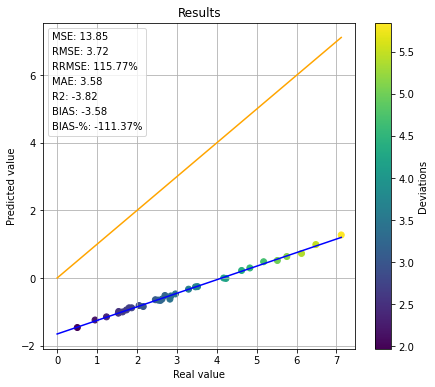

In [ ]:
learn = synth_learner()
interp = RegressionInterpretation.from_learner(learn)
interp.plot_results()
plt.show()

In [ ]:
# export 
def plot_sklearn_regression(model, X:TabularPandas, y:TabularPandas, log_y:bool=False, **kwargs) -> plt.Axes:
    "Similar plotting utility than RegressionInterpretation for scikit-learn models"
    preds = model.predict(X)
    if len(preds.shape) != 2: preds = preds[:,None]
    cols = y.columns
    y = y.values
    if log_y: 
        preds = np.expm1(preds)
        y = np.expm1(y)
    axs = get_grid(y.shape[1], figsize=((6+1)*y.shape[1], (6)*y.shape[1])) # if we have multitarget
    for i, a in enumerate(axs):
        im = a.scatter(y[:,i], preds[:,i], c=np.abs(y[:,i]-preds[:,i]))
        a.set_xlabel('Real value')
        a.set_ylabel('Predicted value')
        a.set_title(cols[i])
        a.grid()
        x = np.linspace(0, max(preds[:,i].max(),y[:,i].max()))
        a.plot(x, x, color='orange')
        m, b = np.polyfit(y[:,i], preds[:,i], 1)
        a.plot(x, m*x+b, color='blue')
        cbar = plt.colorbar(im, ax=a)
        cbar.ax.set_ylabel('Deviations', rotation=90)
        res_mae = mae(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_mse = mse(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_rmse = rmse(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_rrmse = res_rmse / y[:,i].mean() * 100
        r2 = R2Score()(Tensor(y[:,i]), Tensor(preds[:,i]))
        adjusted_r2 = adjusted_R2Score(r2, X.shape[0], X.shape[1])
        res_bias = bias(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_pct_bias = bias_pct(Tensor(y[:,i]), Tensor(preds[:,i]))
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                   lw=0, alpha=0)] * 8
        labels = [f'MSE: {res_mse:.2f}', f'RMSE: {res_rmse:.2f}', f'RRMSE: {res_rrmse:.2f}%',
                  f'MAE: {res_mae:.2f}', f'R2: {r2:.2f}', f'Adj. R2: {adjusted_r2:.2f}',
                  f'BIAS: {res_bias:.2f}', f'BIAS-%: {res_pct_bias:.2f}%']
        a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
    return axs

In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs

Converted 00_data.image.ipynb.
Converted 01_data.las.ipynb.
Converted 02_tabular.preprocessing.ipynb.
Converted 03_model.inception3dv3.ipynb.
Converted 04_interpretation.ipynb.
Converted 05_metrics.ipynb.
Converted 06_model.ensemble.ipynb.
Converted 07_model.alexnet.ipynb.
Converted index.ipynb.
converting: /mnt/d/Users/E1005164/enveco/nbs/01_data.las.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/06_model.ensemble.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/index.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/04_interpretation.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/07_model.alexnet.ipynb
converting /mnt/d/Users/E1005164/enveco/nbs/index.ipynb to README.md
